Подгружаю нужные библиотеки


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

Подгружаю и вывожу данные для их проверки

In [62]:
train_data = pd.read_excel('train.xlsx')
test_data = pd.read_excel('test.xlsx')

print("Тренировочные данные:")
print(train_data.head())
print("Тестовые данные:")
print(test_data.head())

Тренировочные данные:
          dt  Цена на арматуру
0 2015-01-05             32900
1 2015-01-12             32500
2 2015-01-19             32000
3 2015-01-26             30700
4 2015-02-02             30300
Тестовые данные:
          dt  Цена на арматуру
0 2022-09-05             46000
1 2022-09-12             46000
2 2022-09-19             46000
3 2022-09-26             45500
4 2022-10-03             45500


Преобразование дат и предобработка, Удаляю пропуски из данных с помощью dropna,Создаю индикатор времени.

In [63]:
train_data['dt'] = pd.to_datetime(train_data['dt'])
test_data['dt'] = pd.to_datetime(test_data['dt'])

train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

train_data['День'] = (train_data['dt'] - train_data['dt'].min()).dt.days

Создаём признаки и целевую переменную

In [64]:
X_train = train_data[['День']]
y_train = train_data['Цена на арматуру']

Начинаю создавать модель

In [65]:
model = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=5, silent=True)
model.fit(X_train, y_train)

Создаю будующие понедельники и предсказания (10 недель вперёд).Создаю DataFrame для будующих дней.Делаю предсказания для будующих понедельников. Ну и на конец создаю DataFrame с будующими датами и предсказаниями

In [66]:
future_weeks = 10  # 10 недель
last_day = train_data['День'].max()  
future_dates = pd.date_range(start=train_data['dt'].max() + pd.Timedelta(days=7), periods=future_weeks, freq='W-MON')

future_days_index = np.arange(last_day + 1, last_day + future_weeks + 1).reshape(-1, 1)

future_predictions = model.predict(future_days_index)

print(f"Длина future_dates: {len(future_dates)}")
print(f"Длина future_predictions: {len(future_predictions)}")

future_df = pd.DataFrame({'dt': future_dates, 'Цена на арматуру': future_predictions})

Длина future_dates: 10
Длина future_predictions: 10


Начинаю визуализировать результаты

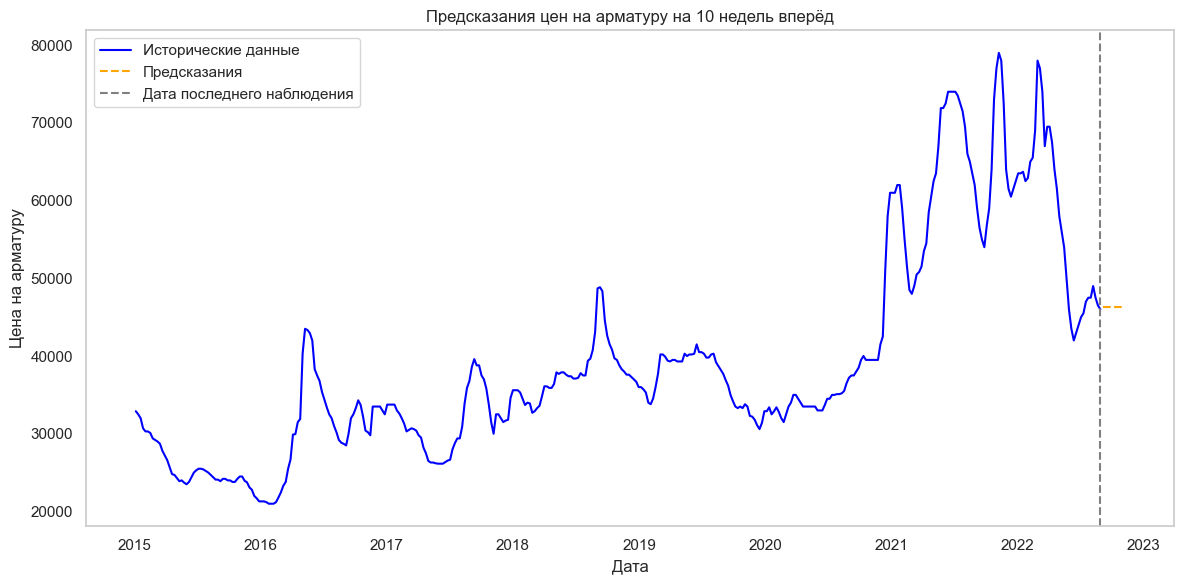

In [67]:
plt.figure(figsize=(12, 6))

plt.plot(train_data['dt'], train_data['Цена на арматуру'], label='Исторические данные', color='blue')

plt.plot(future_df['dt'], future_df['Цена на арматуру'], label='Предсказания', color='orange', linestyle='--')

plt.title('Предсказания цен на арматуру на 10 недель вперёд')
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.axvline(x=train_data['dt'].max(), color='grey', linestyle='--', label='Дата последнего наблюдения')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

После просмотра вижу только одно, модель не обучилась и не смогла предсказать дальнеющую цену и оставила её на одном уровне.

Решаю создать дополнительные признаки и дообучить модель на них

In [68]:
train_data['День'] = train_data['dt'].dt.day
train_data['Месяц'] = train_data['dt'].dt.month
train_data['Год'] = train_data['dt'].dt.year
train_data['ДеньНедели'] = train_data['dt'].dt.dayofweek
train_data['ЦенаL1'] = train_data['Цена на арматуру'].shift(1)  # Лаг 1
train_data['ЦенаL2'] = train_data['Цена на арматуру'].shift(2)  # Лаг 2

train_data.dropna(inplace=True)

Дропнув NaN начинаю заново обучать модель

In [69]:
train_data = pd.read_excel('train.xlsx')

train_data['dt'] = pd.to_datetime(train_data['dt'])

train_data['День'] = train_data['dt'].dt.day
train_data['Месяц'] = train_data['dt'].dt.month
train_data['Год'] = train_data['dt'].dt.year
train_data['ДеньНедели'] = train_data['dt'].dt.dayofweek
train_data['ЦенаL1'] = train_data['Цена на арматуру'].shift(1)
train_data['ЦенаL2'] = train_data['Цена на арматуру'].shift(2)

train_data.dropna(inplace=True)

X_train = train_data[['День', 'Месяц', 'Год', 'ДеньНедели', 'ЦенаL1', 'ЦенаL2']]
y_train = train_data['Цена на арматуру']

model = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, silent=True)
model.fit(X_train, y_train)

Модель создана и можно начать прогнозирование будующих значений

In [70]:
future_weeks = 10
last_day = train_data['dt'].max()

future_dates = pd.date_range(start=last_day + pd.Timedelta(days=1), periods=future_weeks, freq='W-MON')

future_data = pd.DataFrame({
    'День': future_dates.day,
    'Месяц': future_dates.month,
    'Год': future_dates.year,
    'ДеньНедели': future_dates.dayofweek,
})

if len(train_data) > 0:
    last_price = train_data['Цена на арматуру'].iloc[-1]  
    future_data['ЦенаL1'] = last_price  
    future_data['ЦенаL2'] = last_price
else:
    future_data['ЦенаL1'] = 0
    future_data['ЦенаL2'] = 0

Прогнозирую

In [71]:
future_predictions = model.predict(future_data)

Создаю DataFrame с будующими датами и предсказаниями

In [72]:
future_df = pd.DataFrame({'dt': future_dates, 'Цена на арматуру': future_predictions})

Вывожу резуальтаты

In [73]:
print(future_df)

          dt  Цена на арматуру
0 2022-09-05      46395.444698
1 2022-09-12      46193.762805
2 2022-09-19      46703.187278
3 2022-09-26      46573.575602
4 2022-10-03      48836.987354
5 2022-10-10      48301.145025
6 2022-10-17      48382.584609
7 2022-10-24      48033.715565
8 2022-10-31      46819.865598
9 2022-11-07      48307.424269


Строю графики

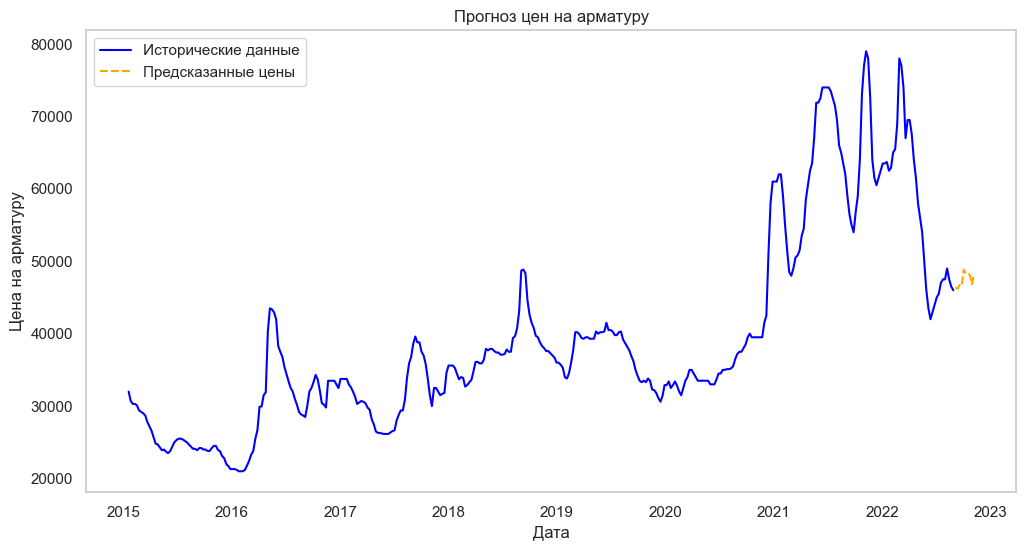

In [74]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['dt'], train_data['Цена на арматуру'], label='Исторические данные', color='blue')
plt.plot(future_df['dt'], future_df['Цена на арматуру'], label='Предсказанные цены', color='orange', linestyle='--')
plt.title('Прогноз цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.legend()
plt.grid()
plt.show()